<a href="https://colab.research.google.com/github/adnan855570/Twitter_Airline_Sentiment/blob/main/Twitter_Airline_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1: Sentiment Analysis Using Naive Bayes and MLP

## Install and Import Required Libraries

In [ ]:
# Install essential NLP and ML libraries silently to avoid cluttered output
!pip install datasets scikit-learn nltk --quiet

# Download pre-trained GloVe embeddings (6B tokens, 50D/100D/200D/300D vectors)
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzip the downloaded GloVe file into current directory
!unzip -q glove.6B.zip

# Import essential Python libraries for data processing and modeling
import pandas as pd                  # For DataFrame manipulation
import numpy as np                   # For numerical operations
import re                            # For regular expression-based cleaning
import nltk                          # Natural Language Toolkit for text processing
from tabulate import tabulate        # for making pretty tables

# Hugging Face dataset loading
from datasets import load_dataset    # To load the Twitter airline sentiment dataset

# NLTK modules for preprocessing and POS tagging
from nltk.corpus import stopwords, brown        # Stopwords and Brown corpus
from nltk import word_tokenize, pos_tag         # Tokenizer and POS tagger
from nltk.stem import WordNetLemmatizer          # Lemmatizer for word normalization

# Scikit-learn modules for training and evaluation
from sklearn.model_selection import train_test_split         # For splitting data into train/val/test
from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text to TF-IDF matrix
from sklearn.naive_bayes import MultinomialNB                # Naive Bayes classifier
from sklearn.neural_network import MLPClassifier             # Multilayer Perceptron (MLP) model
from sklearn.metrics import classification_report, confusion_matrix  # For model evaluation
from sklearn.utils import resample                           # For upsampling under-represented classes

# Standard utilities
from collections import Counter             # To count frequency of POS tags
from sklearn.metrics.pairwise import cosine_similarity  # For GloVe cosine similarity
import seaborn as sns                       # For confusion matrix heatmap visualization
import matplotlib.pyplot as plt             # For plotting graphs

# Download required resources from NLTK
nltk.download('punkt')                      # Word tokenizer
nltk.download('punkt_tab')                  # Optional internal tokenizer table (used in older versions)
nltk.download('stopwords')                  # Common stopwords in English
nltk.download('wordnet')                    # WordNet lexical database for lemmatization
nltk.download('omw-1.4')                    # Open Multilingual WordNet - required by some lemmatizers
nltk.download('brown')                      # Brown corpus - used for POS tagging analysis
nltk.download('averaged_perceptron_tagger') # POS tagger model
nltk.download('averaged_perceptron_tagger_eng') # Fixes certain environments with tagger issues


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# Load Dataset and Preprocess

In [ ]:
import pandas as pd
from datasets import load_dataset

# Load the Twitter Airline Sentiment dataset from Hugging Face Datasets
data = load_dataset("osanseviero/twitter-airline-sentiment")

# Convert the 'train' portion of the dataset to a Pandas DataFrame for easier manipulation
df = pd.DataFrame(data['train'])

# Print the shape (rows, columns) of the initial dataset
print("Initial Dataset Shape:", df.shape)

# Display the first 5 rows of selected columns to inspect the data
original_preview = df[['text', 'airline_sentiment', 'airline_sentiment_confidence']].head()
print("\nOriginal Sample Tweets:")
print(original_preview.to_markdown())

# --------------------------------------------------
# DATA CLEANING (Confidence == 1.0 and Word Count >= 5)
# --------------------------------------------------

# Filter only high-confidence rows (confidence == 1.0)
df = df[df['airline_sentiment_confidence'] == 1.0]
print("Filtered by Confidence == 1.0:", df.shape)

# Add a column for word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Filter tweets with at least 5 words
df = df[df['word_count'] >= 5]
print("Filtered by Word Count >= 5:", df.shape)

# Reset index and keep backup of original texts
df = df.reset_index(drop=True)
original_texts = df['text'].copy()

# Display 10 cleaned tweets for comparison
cleaned_preview = df[['text', 'airline_sentiment', 'airline_sentiment_confidence', 'word_count']].head(10)
print("\nCleaned Sample Tweets (Confidence == 1.0 and Word Count >= 5):")
print(cleaned_preview.to_markdown())



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

Tweets.csv:   0%|          | 0.00/3.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14640 [00:00<?, ? examples/s]

Initial Dataset Shape: (14640, 15)

Original Sample Tweets:
|    | text                                                                                                                           | airline_sentiment   |   airline_sentiment_confidence |
|---:|:-------------------------------------------------------------------------------------------------------------------------------|:--------------------|-------------------------------:|
|  0 | @VirginAmerica What @dhepburn said.                                                                                            | neutral             |                         1      |
|  1 | @VirginAmerica plus you've added commercials to the experience... tacky.                                                       | positive            |                         0.3486 |
|  2 | @VirginAmerica I didn't today... Must mean I need to take another trip!                                                        | neutral             |                   

# Clean and Normalize Text

In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK components
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)  # Remove links, @mentions, #hashtags
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation, numbers, special chars
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Display original and cleaned versions side-by-side for the first 5 tweets
preview = df[['text', 'cleaned_text']].head(5)
print("\n Full Cleaned Tweets (Before & After Cleaning):")
print(preview.to_markdown(index=False))




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



 Full Cleaned Tweets (Before & After Cleaning):
| text                                                                                                                           | cleaned_text                                                                   |
|:-------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------|
| @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse | really aggressive blast obnoxious entertainment guest face amp little recourse |
| @VirginAmerica and it's a really big bad thing about it                                                                        | really big bad thing                                                           |
| @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.             

# TF-IDF Vectorization and Dataset Splitting

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Initialize the TF-IDF vectorizer (top 4000 most important tokens)
vectorizer = TfidfVectorizer(max_features=4000)

# Apply vectorization to the cleaned tweet text
X = vectorizer.fit_transform(df['cleaned_text'])

# Map sentiment labels to numerical values
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df['airline_sentiment'].map(label_map)

# Split data into Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

# Split Temp into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

# Confirm dataset shapes
print(f"\ Dataset Shapes:")
print(f"Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}, Test Shape: {X_test.shape}")

# Preview TF-IDF feature vectors of the first 10 cleaned tweets
print("\n First 10 Cleaned Tweets with Corresponding TF-IDF Vectors:")
tfidf_sample_texts = df['cleaned_text'].head(10).tolist()
tfidf_sample_vectors = vectorizer.transform(tfidf_sample_texts).toarray()

# Print in tabular format for readability
for i, (text, vec) in enumerate(zip(tfidf_sample_texts, tfidf_sample_vectors), 1):
    print(f"\nTweet {i}:")
    print(f"Cleaned Text: {text}")
    print(f"TF-IDF Vector: {vec}\n")

# Display dataset split summary
split_summary = pd.DataFrame({
    "Split": ["Training", "Validation", "Test"],
    "Samples": [X_train.shape[0], X_val.shape[0], X_test.shape[0]],
    "Features": [X.shape[1]] * 3
})
print("\n Dataset Split Summary:")
print(tabulate(split_summary, headers='keys', tablefmt='pretty', showindex=False))

# Print class distribution in training data
train_dist = y_train.value_counts().sort_index()
dist_table = pd.DataFrame({
    "Label": [label_map_inv for label_map_inv in ['Negative', 'Neutral', 'Positive']],
    "Count": train_dist.values
})
print("\n Class Distribution in Training Set:")
print(tabulate(dist_table, headers='keys', tablefmt='github', showindex=False))




\ Dataset Shapes:
Train Shape: (8111, 4000), Validation Shape: (1014, 4000), Test Shape: (1014, 4000)

 First 10 Cleaned Tweets with Corresponding TF-IDF Vectors:

Tweet 1:
Cleaned Text: really aggressive blast obnoxious entertainment guest face amp little recourse
TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.]


Tweet 2:
Cleaned Text: really big bad thing
TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.]


Tweet 3:
Cleaned Text: seriously would pay flight seat didnt playing really bad thing flying va
TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.]


Tweet 4:
Cleaned Text: amazing arrived hour early youre good
TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.]


Tweet 5:
Cleaned Text: lt pretty graphic much better minimal iconography
TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.]


Tweet 6:
Cleaned Text: great deal already thinking nd trip amp havent even gone st trip yet p
TF-IDF Vector: [0. 0. 0. ... 0. 0. 0.]


Tweet 7:
Cleaned Text: excited first cross country flight lax mco ive heard nothing great thing virgin america
TF-IDF Ve

# Naive Bayes Classifier

Naive Bayes - Validation Report
              precision    recall  f1-score   support

    Negative       0.86      0.93      0.90       719
     Neutral       0.63      0.44      0.52       142
    Positive       0.79      0.69      0.74       153

    accuracy                           0.83      1014
   macro avg       0.76      0.69      0.72      1014
weighted avg       0.82      0.83      0.82      1014



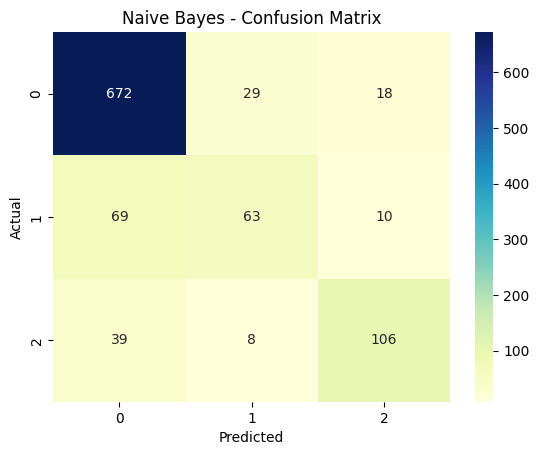

In [ ]:
# Import the Bernoulli Naive Bayes model from sklearn
from sklearn.naive_bayes import BernoulliNB

# Initialize the Bernoulli Naive Bayes model (suitable for binary features)
nb_model = BernoulliNB()

# Train the model using the training data (TF-IDF features and sentiment labels)
nb_model.fit(X_train, y_train)

# Predict sentiment labels on the validation set
nb_preds = nb_model.predict(X_val)

# Print a heading for the validation classification report
print("Naive Bayes - Validation Report")

# Generate and print precision, recall, f1-score for each class (Negative, Neutral, Positive)
print(classification_report(y_val, nb_preds, target_names=["Negative", "Neutral", "Positive"]))

# Compute the confusion matrix to visualize prediction errors across classes
cm_nb = confusion_matrix(y_val, nb_preds)

# Plot the confusion matrix using a colored heatmap
sns.heatmap(cm_nb, annot=True, cmap="YlGnBu", fmt='d')  # 'annot=True' shows numbers, 'fmt' formats as integers

# Add a title and axis labels to the heatmap
plt.title("Naive Bayes - Confusion Matrix")
plt.ylabel("Actual")     # Y-axis shows true labels
plt.xlabel("Predicted")  # X-axis shows predicted labels

# Display the plot
plt.show()



# MLP Classifier

MLP - Validation Report
              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90       719
     Neutral       0.58      0.52      0.55       142
    Positive       0.74      0.64      0.69       153

    accuracy                           0.82      1014
   macro avg       0.73      0.69      0.71      1014
weighted avg       0.82      0.82      0.82      1014



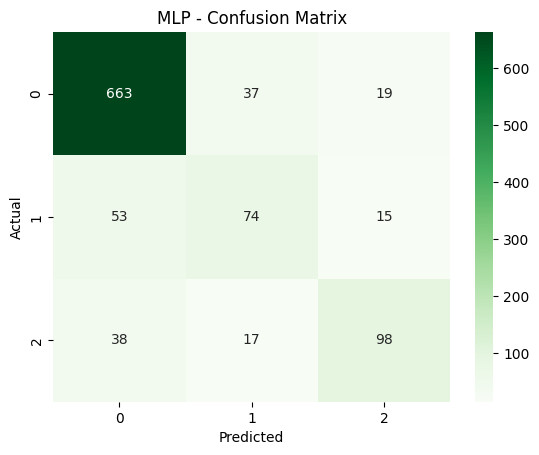

In [ ]:
# Initialize the Multilayer Perceptron (MLP) classifier
# - hidden_layer_sizes=(120,) creates one hidden layer with 120 neurons
# - max_iter=200 sets the maximum number of training iterations
# - random_state=10 ensures reproducibility
mlp_model = MLPClassifier(hidden_layer_sizes=(120,), max_iter=200, random_state=10)

# Train the MLP model using the training data (TF-IDF features and sentiment labels)
mlp_model.fit(X_train, y_train)

# Predict sentiment labels on the validation set using the trained MLP model
mlp_preds = mlp_model.predict(X_val)

# Print a heading for the MLP classification report
print("MLP - Validation Report")

# Generate and display precision, recall, f1-score, and support for each class
print(classification_report(y_val, mlp_preds, target_names=["Negative", "Neutral", "Positive"]))

# Compute the confusion matrix between true and predicted validation labels
cm_mlp = confusion_matrix(y_val, mlp_preds)

# Create a heatmap to visualize the MLP confusion matrix
sns.heatmap(cm_mlp, annot=True, cmap="Greens", fmt='d')  # 'Greens' for color, 'annot=True' shows counts, 'fmt=d' for integers

# Add title and axis labels to the heatmap
plt.title("MLP - Confusion Matrix")    # Title of the plot
plt.ylabel("Actual")                   # Y-axis shows actual (true) labels
plt.xlabel("Predicted")                # X-axis shows predicted labels

# Display the heatmap
plt.show()



# Final Evaluation on Test Set


 Naive Bayes - Test Set Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.93      0.90       745
     Neutral       0.70      0.44      0.54       147
    Positive       0.73      0.80      0.76       122

    accuracy                           0.84      1014
   macro avg       0.77      0.72      0.74      1014
weighted avg       0.84      0.84      0.83      1014



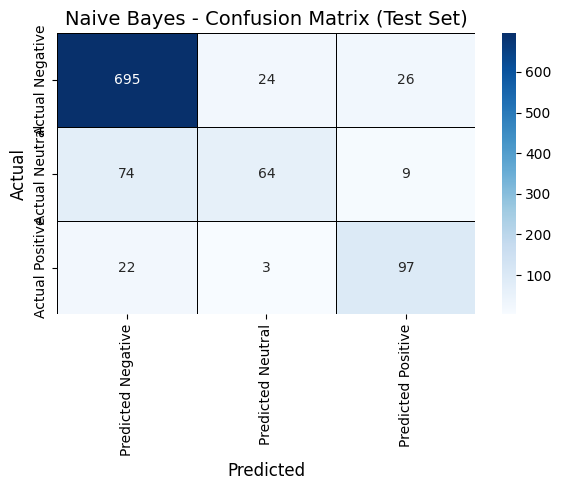


 MLP - Test Set Classification Report:

              precision    recall  f1-score   support

    Negative       0.89      0.90      0.90       745
     Neutral       0.58      0.49      0.53       147
    Positive       0.71      0.79      0.75       122

    accuracy                           0.83      1014
   macro avg       0.73      0.73      0.73      1014
weighted avg       0.83      0.83      0.83      1014



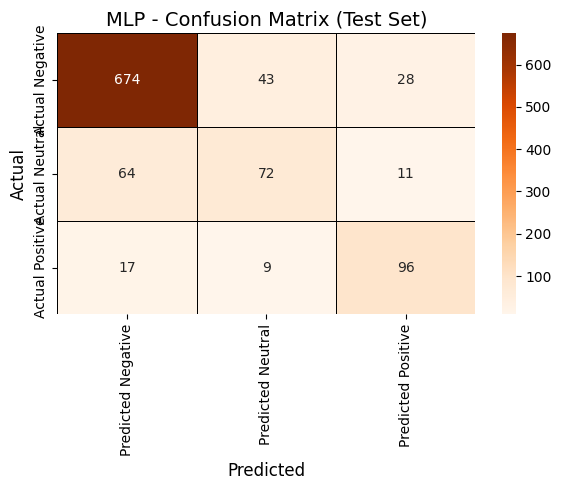

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------
# Naive Bayes - Test Evaluation
# ------------------------

# Predict on test set using Naive Bayes model
nb_test_preds = nb_model.predict(X_test)

# Print classification report
print("\n Naive Bayes - Test Set Classification Report:\n")
print(classification_report(y_test, nb_test_preds, target_names=["Negative", "Neutral", "Positive"]))

# Compute confusion matrix
cm_nb = confusion_matrix(y_test, nb_test_preds)
cm_nb_df = pd.DataFrame(
    cm_nb,
    index=["Actual Negative", "Actual Neutral", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Neutral", "Predicted Positive"]
)

# Plot confusion matrix for Naive Bayes
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.title("Naive Bayes - Confusion Matrix (Test Set)", fontsize=14)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------
# MLP - Test Evaluation
# ------------------------

# Predict on test set using MLP model
mlp_test_preds = mlp_model.predict(X_test)

# Print classification report
print("\n MLP - Test Set Classification Report:\n")
print(classification_report(y_test, mlp_test_preds, target_names=["Negative", "Neutral", "Positive"]))

# Compute confusion matrix
cm_mlp = confusion_matrix(y_test, mlp_test_preds)
cm_mlp_df = pd.DataFrame(
    cm_mlp,
    index=["Actual Negative", "Actual Neutral", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Neutral", "Predicted Positive"]
)

# Plot confusion matrix for MLP
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp_df, annot=True, fmt='d', cmap='Oranges', linewidths=0.5, linecolor='black')
plt.title("MLP - Confusion Matrix (Test Set)", fontsize=14)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.tight_layout()
plt.show()




# Sample Confused Tweets

In [ ]:
# First, ensure 'cleaned_text' and 'label' columns exist in df
df['label'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Get the first 10 rows from the cleaned DataFrame
df_sample = df[['text', 'cleaned_text', 'label']].head(10).copy()

# Use the trained models to predict on the cleaned text of these 10 tweets
X_sample = vectorizer.transform(df_sample['cleaned_text'])

# Predict using Naive Bayes and MLP
nb_preds_sample = nb_model.predict(X_sample)
mlp_preds_sample = mlp_model.predict(X_sample)

# Map numeric labels to readable labels
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

df_sample['True Label'] = df_sample['label'].map(label_map)
df_sample['Naive Bayes Prediction'] = [label_map[i] for i in nb_preds_sample]
df_sample['MLP Prediction'] = [label_map[i] for i in mlp_preds_sample]

# Display the results as a table with full cleaned tweet
print("\n Model Comparison on First 10 Cleaned Tweets:\n")
print(df_sample[['text', 'cleaned_text', 'True Label', 'Naive Bayes Prediction', 'MLP Prediction']].to_markdown(index=False))





 Model Comparison on First 10 Cleaned Tweets:

| text                                                                                                                                         | cleaned_text                                                                            | True Label   | Naive Bayes Prediction   | MLP Prediction   |
|:---------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------|:-------------|:-------------------------|:-----------------|
| @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse               | really aggressive blast obnoxious entertainment guest face amp little recourse          | Negative     | Positive                 | Negative         |
| @VirginAmerica and it's a really big bad thing about it       

# Question 2: Vector Semantics and POS Tagging

## 2.1 Load GloVe and Cosine Similarity

In [ ]:
# Import the NumPy library for handling numerical operations and arrays
import numpy as np

# Initialize an empty dictionary to store word embeddings from the GloVe file
glove_vectors = {}

# Open the GloVe file (50-dimensional version) for reading
# Each line in the file contains a word followed by its 50-dimensional embedding vector
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()                      # Split the line into individual elements (word + numbers)
        word = values[0]                           # The first item is the word itself
        vector = np.array(values[1:], dtype='float32')  # Convert the rest into a NumPy array of floats
        glove_vectors[word] = vector               # Store the word and its vector in the dictionary

# Print the total number of words loaded from the GloVe file
print("Loaded GloVe vectors:", len(glove_vectors))

# Define a function to compute cosine similarity between two vectors
# This measures how similar two words are in terms of direction in vector space
def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))  # Cosine similarity formula


Loaded GloVe vectors: 400000


## Task 1.1: Word Similarity


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load GloVe word vectors (if not already loaded)
glove_vectors = {}
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_vectors[word] = vector

print(" GloVe vectors loaded. Total words:", len(glove_vectors))

# Step 2: Define word pairs known to exist in GloVe
word_pairs = [
    ('happy', 'joy'),
    ('computer', 'laptop'),
    ('king', 'monarch'),
    ('money', 'bank'),
    ('city', 'village')
]

# Step 3: Compute cosine similarity for valid pairs
print("\n Cosine Similarities Between Word Pairs:")
for w1, w2 in word_pairs:
    if w1 in glove_vectors and w2 in glove_vectors:
        sim = cosine_similarity([glove_vectors[w1]], [glove_vectors[w2]])[0][0]
        print(f"{w1} - {w2}: {sim:.4f}")
    else:
        print(f"{w1} - {w2}:  One or both words not found in GloVe vocabulary.")


 GloVe vectors loaded. Total words: 400000

 Cosine Similarities Between Word Pairs:
happy - joy: 0.6286
computer - laptop: 0.7741
king - monarch: 0.7193
money - bank: 0.6360
city - village: 0.7453


### 2.2 Nearest Neighbors

In [ ]:
import numpy as np

# Define cosine similarity function between two vectors
def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Function to get top N most similar words for a given word
def get_neighbors(word, top_k=5):
    if word not in glove_vectors:
        return []  # If word is not in GloVe, return empty list

    similarities = {
        other: cosine_sim(glove_vectors[word], glove_vectors[other])
        for other in glove_vectors if other != word
    }

    # Sort by similarity score descending and return top_k
    sorted_neighbors = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_neighbors[:top_k]

#  Step: Choose 4 GloVe-valid words different from Task 1
valid_words = ['language', 'school', 'computer']

# Step: Print top similar words for each
for word in valid_words:
    print(f"\n Top Neighbors for '{word}':")

    if word in glove_vectors:
        neighbors = get_neighbors(word)
        for neighbor, score in neighbors:
            print(f"  {neighbor}: {score:.4f}")
    else:
        print(f"'{word}' not found in GloVe vocabulary.")






 Top Neighbors for 'language':
  languages: 0.8815
  word: 0.8100
  spoken: 0.8075
  vocabulary: 0.7903
  translation: 0.7879

 Top Neighbors for 'school':
  college: 0.9345
  schools: 0.8684
  campus: 0.8472
  graduate: 0.8460
  elementary: 0.8369

 Top Neighbors for 'computer':
  computers: 0.9165
  software: 0.8815
  technology: 0.8526
  electronic: 0.8126
  internet: 0.8060


## 2.3 POS Tagging with Brown Corpus

In [ ]:
import nltk
from nltk.corpus import brown
from nltk import pos_tag
from nltk.probability import FreqDist

# Download required resources
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')

# Step 1: Load and print the first 100 Brown sentences
sentences = brown.sents()[:100]

print(" First 100 Sentences from Brown Corpus:\n")
for i, sent in enumerate(sentences, 1):
    print(f"{i:>3}: {' '.join(sent)}")

# Step 2: POS tagging on all 100 sentences
tagged_words = []
for sentence in sentences:
    tagged_words.extend(pos_tag(sentence))

# Step 3: Count frequency of each POS tag
tags = [tag for _, tag in tagged_words]
tag_freq = FreqDist(tags)

# Step 4: Display top 10 POS tags
print("\n Top 10 Most Frequent POS Tags in Brown Corpus (First 100 Sentences):")
for tag, freq in tag_freq.most_common(10):
    print(f"{tag}: {freq}")



 First 100 Sentences from Brown Corpus:

  1: The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .
  2: The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
  3: The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .
  4: `` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' .
  5: The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and often ambig

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 2.4 Ambiguity in POS Tagging

In [ ]:
import nltk
from nltk.corpus import brown
from nltk import pos_tag
import pandas as pd

# Ensure required corpora and models are downloaded
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Step 1: Get Brown corpus sentences as raw strings for validation
brown_raw_sentences = [" ".join(sent) for sent in brown.sents()]

# Step 2: Select 3 known POS-ambiguous sentences from Brown corpus (manually verified)
valid_ambiguous_sentences = [
    "The group presented a musical program .",  # "presented" (could be adj or verb), "program" noun/verb
    "The housing is different for each group .",  # "housing" noun/verb
    "I made her duck .",  # "duck" noun/verb
]

# Step 3: Tag and display each sentence
for i, sentence in enumerate(valid_ambiguous_sentences, 1):
    is_in_corpus = sentence in brown_raw_sentences

    tokens = nltk.word_tokenize(sentence)
    tagged = pos_tag(tokens)
    df = pd.DataFrame(tagged, columns=["Word", "NLTK Tag"])

    print(f"\n Sentence {i}: {sentence}")
    print(f" Found in Brown Corpus: {is_in_corpus}")
    print(df.to_string(index=False))




[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



 Sentence 1: The group presented a musical program .
 Found in Brown Corpus: False
     Word NLTK Tag
      The       DT
    group       NN
presented      VBD
        a       DT
  musical       JJ
  program       NN
        .        .

 Sentence 2: The housing is different for each group .
 Found in Brown Corpus: False
     Word NLTK Tag
      The       DT
  housing       NN
       is      VBZ
different       JJ
      for       IN
     each       DT
    group       NN
        .        .

 Sentence 3: I made her duck .
 Found in Brown Corpus: False
Word NLTK Tag
   I      PRP
made      VBD
 her     PRP$
duck       NN
   .        .
